## Import libraries

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np
import os

import albumentations as A
from albumentations.pytorch import ToTensorV2

import seaborn as sns
from src import *
import torchsummary

## Data preprocessing

In [5]:
download_and_unzip("https://proai-datasets.s3.eu-west-3.amazonaws.com/dataset_food_classification.zip")

I file sono stati estratti in: C:\Users\gcusumano\ProfAI\GourmetAI


In [5]:
class Transforms:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

transform = A.Compose([
        A.Resize(256, 256),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.Rotate(limit=90),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1),
        A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ToTensorV2(),
      ])

In [6]:
trainset = torchvision.datasets.ImageFolder(root='dataset/train', transform=Transforms(transform))

valset = torchvision.datasets.ImageFolder(root='dataset/val', transform=Transforms(transform))

testset = torchvision.datasets.ImageFolder(root='dataset/test',transform=Transforms(transform))

In [7]:
len(trainset), len(valset), len(testset)

(8960, 2240, 2800)

In [8]:
batch_size = 2
num_batches = 2
from torch.utils.data import Subset
num_samples = num_batches * batch_size
subset_indices = list(range(num_samples)) 
limited_trainset = Subset(trainset, subset_indices)
limited_valset = Subset(valset, subset_indices)
limited_testset = Subset(testset, subset_indices)

trainloader = torch.utils.data.DataLoader(limited_trainset, batch_size=batch_size,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(limited_valset, batch_size=batch_size,
                                          shuffle=False)

testloader = torch.utils.data.DataLoader(limited_testset, batch_size=batch_size,
                                         shuffle=False)

## Transfer Learning

In [9]:
torch.cuda.empty_cache()
vgg = models.vgg16(pretrained=True)

for param in vgg.parameters():
    param.requires_grad = False

last_layer = vgg.classifier[-1]
last_layer_n_features = last_layer.in_features
classes = trainset.classes
vgg.classifier[-1] = nn.Linear(last_layer_n_features, len(classes))
torchsummary.summary(vgg,(3,256,256))

c:\Users\gcusumano\ProfAI\GourmetAI\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gcusumano\ProfAI\GourmetAI\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

## Training options

### logger + exp

In [12]:
import numpy as np
import os
import torch
import shutil
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import logging
import importlib

def get_logger(ch_log_level=logging.ERROR, 
               fh_log_level=logging.INFO):
    logging.shutdown()
    importlib.reload(logging)  # Sostituito imp.reload con importlib.reload
    logger = logging.getLogger("cheatsheet")
    logger.setLevel(logging.DEBUG)
    
    # Console Handler
    if ch_log_level:
        ch = logging.StreamHandler()
        ch.setLevel(ch_log_level)
        ch.setFormatter(logging.Formatter('%(message)s'))
        logger.addHandler(ch)
    
    # File Handler
    if fh_log_level:
        fh = logging.FileHandler('cheatsheet.log')
        fh.setLevel(fh_log_level)
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        fh.setFormatter(formatter)
        logger.addHandler(fh)

    return logger

class Experiment():
    def __init__(self, name, root, logger=None):
        self.name = name
        self.root = os.path.join(root, name)
        self.logger = logger
        self.epoch = 1
        self.best_val_loss = sys.maxsize
        self.best_val_loss_epoch = 1
        self.weights_dir = os.path.join(self.root, 'weights')
        self.history_dir = os.path.join(self.root, 'history')
        self.results_dir = os.path.join(self.root, 'results')
        self.latest_weights = os.path.join(self.weights_dir, 'latest_weights.pth')
        self.latest_optimizer = os.path.join(self.weights_dir, 'latest_optim.pth')
        self.best_weights_path = self.latest_weights
        self.best_optimizer_path = self.latest_optimizer
        self.train_history_fpath = os.path.join(self.history_dir, 'train.csv')
        self.val_history_fpath = os.path.join(self.history_dir, 'val.csv')
        self.test_history_fpath = os.path.join(self.history_dir, 'test.csv')
        self.loss_history = {
            'train': np.array([]),
            'val': np.array([]),
            'test': np.array([])
        }
        self.acc_history = {
            'train': np.array([]),
            'val': np.array([]),
            'test': np.array([])
        }
        
    def log(self, msg):
        if self.logger:
            self.logger.info(msg)
        
    def init(self):
        self.log("Creating new experiment")
        self.init_dirs()
        self.init_history_files()

    def resume(self, model, optim, weights_fpath=None, optim_path=None):
        self.log("Resuming existing experiment")
        if weights_fpath is None:
            weights_fpath = self.latest_weights
        if optim_path is None:
            optim_path = self.latest_optimizer

        model, state = self.load_weights(model, weights_fpath)
        optim = self.load_optimizer(optim, optim_path)

        self.best_val_loss = state['best_val_loss']
        self.best_val_loss_epoch = state['best_val_loss_epoch']
        self.epoch = state['last_epoch'] + 1
        self.load_history_from_file('train')
        self.load_history_from_file('val')

        return model, optim

    def init_dirs(self):
        os.makedirs(self.weights_dir, exist_ok=True)
        os.makedirs(self.history_dir, exist_ok=True)
        os.makedirs(self.results_dir, exist_ok=True)
        
    def init_history_files(self):
        Path(self.train_history_fpath).touch()
        Path(self.val_history_fpath).touch()
        Path(self.test_history_fpath).touch()

    def load_history_from_file(self, dset_type):
        fpath = os.path.join(self.history_dir, dset_type + '.csv')
        try:
            data = np.loadtxt(fpath, delimiter=',').reshape(-1, 3)
            self.loss_history[dset_type] = data[:, 1]
            self.acc_history[dset_type] = data[:, 2]
        except:
            self.loss_history[dset_type] = np.array([])
            self.acc_history[dset_type] = np.array([])

    def append_history_to_file(self, dset_type, loss, acc):
        fpath = os.path.join(self.history_dir, dset_type + '.csv')
        with open(fpath, 'a') as f:
            f.write('{},{},{}\n'.format(self.epoch, loss, acc))

    def save_history(self, dset_type, loss, acc):
        self.loss_history[dset_type] = np.append(self.loss_history[dset_type], loss)
        self.acc_history[dset_type] = np.append(self.acc_history[dset_type], loss)
        self.append_history_to_file(dset_type, loss, acc)

        if dset_type == 'val' and self.is_best_loss(loss):
            self.best_val_loss = loss
            self.best_val_loss_epoch = self.epoch
            
        # Plot and save after each update
        if dset_type == 'val':
            self.plot_and_save_history()

    def is_best_loss(self, loss):
        return loss < self.best_val_loss

    def save_weights(self, model, trn_loss, val_loss, trn_acc, val_acc):
        weights_fname = self.name + '-weights-%d-%.3f-%.3f-%.3f-%.3f.pth' % (
            self.epoch, trn_loss, trn_acc, val_loss, val_acc)
        weights_fpath = os.path.join(self.weights_dir, weights_fname)
        torch.save({
            'last_epoch': self.epoch,
            'trn_loss': trn_loss,
            'val_loss': val_loss,
            'trn_acc': trn_acc,
            'val_acc': val_acc,
            'best_val_loss': self.best_val_loss,
            'best_val_loss_epoch': self.best_val_loss_epoch,
            'experiment': self.name,
            'state_dict': model.state_dict()
        }, weights_fpath)
        shutil.copyfile(weights_fpath, self.latest_weights)
        if self.is_best_loss(val_loss):
            self.best_weights_path = weights_fpath

    def load_weights(self, model, fpath):
        self.log("loading weights '{}'".format(fpath))
        state = torch.load(fpath)
        model.load_state_dict(state['state_dict'])
        self.log("loaded weights from experiment %s (last_epoch %d, trn_loss %s, trn_acc %s, val_loss %s, val_acc %s)" % (
            self.name, state['last_epoch'], state['trn_loss'],
            state['trn_acc'], state['val_loss'], state['val_acc']))
        return model, state

    def save_optimizer(self, optimizer, val_loss):
        optim_fname = self.name + '-optim-%d.pth' % (self.epoch)
        optim_fpath = os.path.join(self.weights_dir, optim_fname)
        torch.save({
            'last_epoch': self.epoch,
            'experiment': self.name,
            'state_dict': optimizer.state_dict()
        }, optim_fpath)
        shutil.copyfile(optim_fpath, self.latest_optimizer)
        if self.is_best_loss(val_loss):
            self.best_optimizer_path = optim_fpath

    def load_optimizer(self, optimizer, fpath):
        self.log("loading optimizer '{}'".format(fpath))
        optim = torch.load(fpath)
        optimizer.load_state_dict(optim['state_dict'])
        self.log("loaded optimizer from session {}, last_epoch {}"
                 .format(optim['experiment'], optim['last_epoch']))
        return optimizer

    def plot_and_save_history(self):
        if not hasattr(self, 'monitor'):
            # Inizializza il monitor se non esiste
            self.monitor = ColabTrainingMonitor(figsize=(12, 8))
            
        try:
            # Carica i dati dai file CSV
            if os.path.exists(self.train_history_fpath) and os.path.exists(self.val_history_fpath):
                train_data = np.loadtxt(self.train_history_fpath, delimiter=',')
                val_data = np.loadtxt(self.val_history_fpath, delimiter=',')
                
                # Gestisce il caso di una singola riga
                if train_data.ndim == 1:
                    train_data = train_data.reshape(1, -1)
                if val_data.ndim == 1:
                    val_data = val_data.reshape(1, -1)
                
                # Prende l'ultimo epoch e i valori corrispondenti
                latest_epoch = int(train_data[-1, 0])
                train_loss = train_data[-1, 1]
                train_acc = train_data[-1, 2]
                val_loss = val_data[-1, 1]
                val_acc = val_data[-1, 2]
                
                # Aggiorna il monitor con i nuovi dati
                self.monitor.update(
                    epoch=latest_epoch,
                    train_loss=train_loss,
                    val_loss=val_loss,
                    train_acc=train_acc,
                    val_acc=val_acc
                )
                
                # Salva il plot nella directory history
                self.monitor.save(os.path.join(self.history_dir, 'training_progress.png'))
                
        except Exception as e:
            if self.logger:
                self.logger.warning(f"Error updating plot: {e}")

    # def plot_and_save_history(self):
    #     if not hasattr(self, 'interactive_plot'):
    #         self.interactive_plot = InteractivePlot(
    #             self.train_history_fpath, 
    #             self.val_history_fpath, 
    #             self.history_dir
    #         )
    #         # Avvia il plotting in un thread separato
    #         from threading import Thread
    #         self.plot_thread = Thread(target=self.interactive_plot.run, args=(1,), daemon=True)
    #         self.plot_thread.start()

### InteractivePlot

In [127]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import os
import time
from threading import Thread
import dash
from dash import html, dcc
from dash.dependencies import Input, Output
import webbrowser

class PlotlyTrainingMonitor:
    def __init__(self, train_history_fpath, val_history_fpath, history_dir, port=8050):
        self.train_history_fpath = train_history_fpath
        self.val_history_fpath = val_history_fpath
        self.history_dir = history_dir
        self.port = port
        self.is_running = True
        
        # Initialize the Dash app
        self.app = dash.Dash(__name__)
        
        # Create the layout
        self.app.layout = html.Div([
            html.H1('Training Progress Monitor', style={'textAlign': 'center'}),
            dcc.Graph(id='live-graph'),
            dcc.Interval(
                id='interval-component',
                interval=1*1000,  # update every second
                n_intervals=0
            )
        ])
        
        # Define callback to update graph
        @self.app.callback(
            Output('live-graph', 'figure'),
            [Input('interval-component', 'n_intervals')]
        )
        def update_graph(n):
            return self.create_figure()
    
    def create_figure(self):
        """Create and update the plotly figure"""
        fig = make_subplots(
            rows=2, cols=1,
            subplot_titles=('Loss Over Time', 'Accuracy Over Time'),
            vertical_spacing=0.15
        )
        
        try:
            # Load training data
            if os.path.exists(self.train_history_fpath) and os.path.getsize(self.train_history_fpath) > 0:
                train_data = np.loadtxt(self.train_history_fpath, delimiter=',')
                if train_data.ndim == 1:  # Se c'è una sola riga
                    train_data = train_data.reshape(1, -1)
                train_epochs = train_data[:, 0]
                train_loss = train_data[:, 1]
                train_acc = train_data[:, 2]
                
                # Add training traces
                fig.add_trace(
                    go.Scatter(x=train_epochs, y=train_loss, name='Train Loss',
                             mode='lines+markers', line=dict(color='blue')),
                    row=1, col=1
                )
                fig.add_trace(
                    go.Scatter(x=train_epochs, y=train_acc, name='Train Accuracy',
                             mode='lines+markers', line=dict(color='blue')),
                    row=2, col=1
                )
            
            # Load validation data
            if os.path.exists(self.val_history_fpath) and os.path.getsize(self.val_history_fpath) > 0:
                val_data = np.loadtxt(self.val_history_fpath, delimiter=',')
                if val_data.ndim == 1:  # Se c'è una sola riga
                    val_data = val_data.reshape(1, -1)
                val_epochs = val_data[:, 0]
                val_loss = val_data[:, 1]
                val_acc = val_data[:, 2]
                
                # Add validation traces
                fig.add_trace(
                    go.Scatter(x=val_epochs, y=val_loss, name='Val Loss',
                             mode='lines+markers', line=dict(color='red')),
                    row=1, col=1
                )
                fig.add_trace(
                    go.Scatter(x=val_epochs, y=val_acc, name='Val Accuracy',
                             mode='lines+markers', line=dict(color='red')),
                    row=2, col=1
                )
        
        except Exception as e:
            print(f"Error loading data: {e}")
        
        # Update layout
        fig.update_layout(
            height=800,
            showlegend=True,
            title_text="Training Progress",
            title_x=0.5,
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01
            )
        )
        
        # Update axes
        fig.update_yaxes(title_text="Loss", type="log", row=1, col=1)
        fig.update_yaxes(title_text="Accuracy", row=2, col=1)
        fig.update_xaxes(title_text="Epoch", row=1, col=1)
        fig.update_xaxes(title_text="Epoch", row=2, col=1)
        
        return fig
    
    def save_current_plot(self):
        """Save the current plot state as a static image"""
        try:
            fig = self.create_figure()
            fig.write_image(os.path.join(self.history_dir, 'training_progress.png'))
        except Exception as e:
            print(f"Error saving plot: {e}")
    
    def run_server(self):
        """Run the Dash server"""
        self.app.run_server(debug=False, port=self.port)
    
    def start(self):
        """Start the monitoring server in a separate thread and open the browser"""
        # Start the server in a separate thread
        self.server_thread = Thread(target=self.run_server, daemon=True)
        self.server_thread.start()
        
        # Open the browser after a short delay to ensure the server is running
        time.sleep(2)
        webbrowser.open(f'http://localhost:{self.port}')
    
    def stop(self):
        """Stop the monitoring server"""
        self.is_running = False
        self.save_current_plot()

def setup_training_monitor(experiment):
    """Helper function to set up the training monitor for an experiment"""
    monitor = PlotlyTrainingMonitor(
        train_history_fpath=experiment.train_history_fpath,
        val_history_fpath=experiment.val_history_fpath,
        history_dir=experiment.history_dir
    )
    return monitor

### colab interaactive plot

In [15]:
import matplotlib.pyplot as plt 
import numpy as np
import os
from IPython.display import clear_output

class ColabTrainingMonitor:
    def __init__(self, figsize=(12, 8)):
        """
        Initialize the training monitor
        Args:
            figsize: tuple of width, height for the figure
        """
        self.figsize = figsize
        # Storage for metrics
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []
        self.epochs = []
        
        # Setup the style
        plt.style.use('default')  # Using default style instead of seaborn
        
    def update(self, epoch, train_loss, val_loss, train_acc, val_acc):
        """
        Update the monitor with new metrics
        Args:
            epoch: current epoch number
            train_loss: training loss value
            val_loss: validation loss value
            train_acc: training accuracy value
            val_acc: validation accuracy value
        """
        # Append new values
        self.epochs.append(epoch)
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.train_accs.append(train_acc)
        self.val_accs.append(val_acc)
        
        # Clear the previous output and display new plots
        clear_output(wait=True)
        self.plot()
        
    def plot(self):
        """Plot the current training progress"""
        # Create figure and axes
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=self.figsize)
        fig.suptitle('Training Progress', fontsize=16, y=1.02)
        
        # Plot Loss with enhanced styling
        ax1.plot(self.epochs, self.train_losses, 'b-o', label='Training Loss', 
                markersize=4, linewidth=2, alpha=0.8)
        ax1.plot(self.epochs, self.val_losses, 'r-o', label='Validation Loss', 
                markersize=4, linewidth=2, alpha=0.8)
        ax1.set_title('Loss Over Time', pad=10)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_yscale('log')
        ax1.grid(True, linestyle='--', alpha=0.7)
        ax1.legend(loc='upper right', frameon=True)
        ax1.set_facecolor('#f8f9fa')
        
        # Add value annotations for the last point
        if self.train_losses:
            ax1.annotate(f'{self.train_losses[-1]:.4f}', 
                        (self.epochs[-1], self.train_losses[-1]),
                        xytext=(5, 5), textcoords='offset points',
                        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
            ax1.annotate(f'{self.val_losses[-1]:.4f}',
                        (self.epochs[-1], self.val_losses[-1]),
                        xytext=(5, 5), textcoords='offset points',
                        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
        
        # Plot Accuracy with enhanced styling
        ax2.plot(self.epochs, self.train_accs, 'b-o', label='Training Accuracy', 
                markersize=4, linewidth=2, alpha=0.8)
        ax2.plot(self.epochs, self.val_accs, 'r-o', label='Validation Accuracy', 
                markersize=4, linewidth=2, alpha=0.8)
        ax2.set_title('Accuracy Over Time', pad=10)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.grid(True, linestyle='--', alpha=0.7)
        ax2.legend(loc='lower right', frameon=True)
        ax2.set_facecolor('#f8f9fa')
        
        # Add value annotations for the last point
        if self.train_accs:
            ax2.annotate(f'{self.train_accs[-1]:.4f}',
                        (self.epochs[-1], self.train_accs[-1]),
                        xytext=(5, 5), textcoords='offset points',
                        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
            ax2.annotate(f'{self.val_accs[-1]:.4f}',
                        (self.epochs[-1], self.val_accs[-1]),
                        xytext=(5, 5), textcoords='offset points',
                        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
        
        # Enhance figure appearance
        fig.patch.set_facecolor('white')
        plt.tight_layout()
        plt.show()
        
    def save(self, filepath):
        """
        Save the current plot to a file
        Args:
            filepath: path where to save the plot
        """
        # Create figure and save
        self.plot()
        plt.savefig(filepath, bbox_inches='tight', dpi=300, facecolor='white')
    
    def get_current_metrics(self):
        """Return the latest metrics"""
        if not self.epochs:
            return None
        
        return {
            'epoch': self.epochs[-1],
            'train_loss': self.train_losses[-1],
            'val_loss': self.val_losses[-1],
            'train_acc': self.train_accs[-1],
            'val_acc': self.val_accs[-1]
        }
    
    def load_from_csv(self, train_file, val_file):
        """
        Load metrics from CSV files
        Args:
            train_file: path to training metrics CSV
            val_file: path to validation metrics CSV
        """
        try:
            if os.path.exists(train_file) and os.path.exists(val_file):
                train_data = np.loadtxt(train_file, delimiter=',')
                val_data = np.loadtxt(val_file, delimiter=',')
                
                # Handle single row case
                if train_data.ndim == 1:
                    train_data = train_data.reshape(1, -1)
                if val_data.ndim == 1:
                    val_data = val_data.reshape(1, -1)
                
                # Reset current data
                self.epochs = train_data[:, 0].tolist()
                self.train_losses = train_data[:, 1].tolist()
                self.train_accs = train_data[:, 2].tolist()
                self.val_losses = val_data[:, 1].tolist()
                self.val_accs = val_data[:, 2].tolist()
                
                # Plot updated data
                self.plot()
                
        except Exception as e:
            print(f"Error loading data from CSV: {e}")
            
    def stop(self):
        """Cleanup method"""
        plt.close('all')

### New Experiment

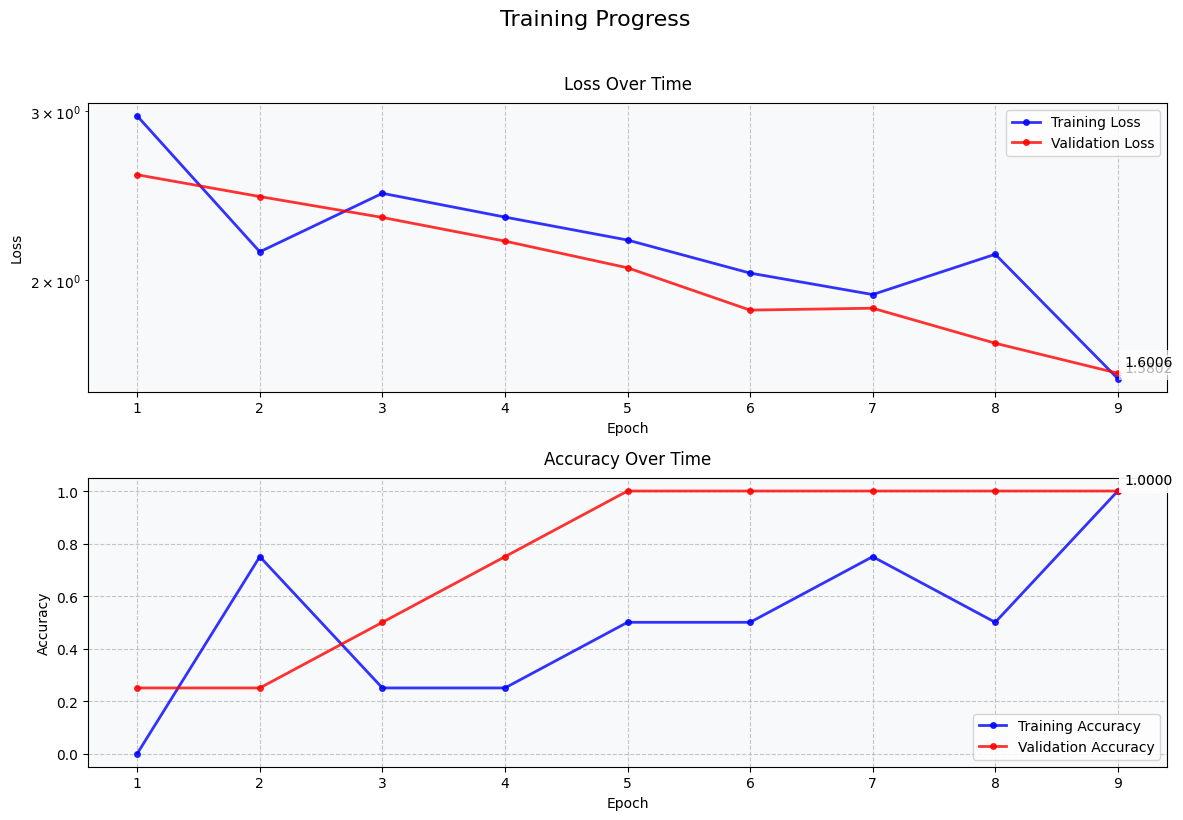

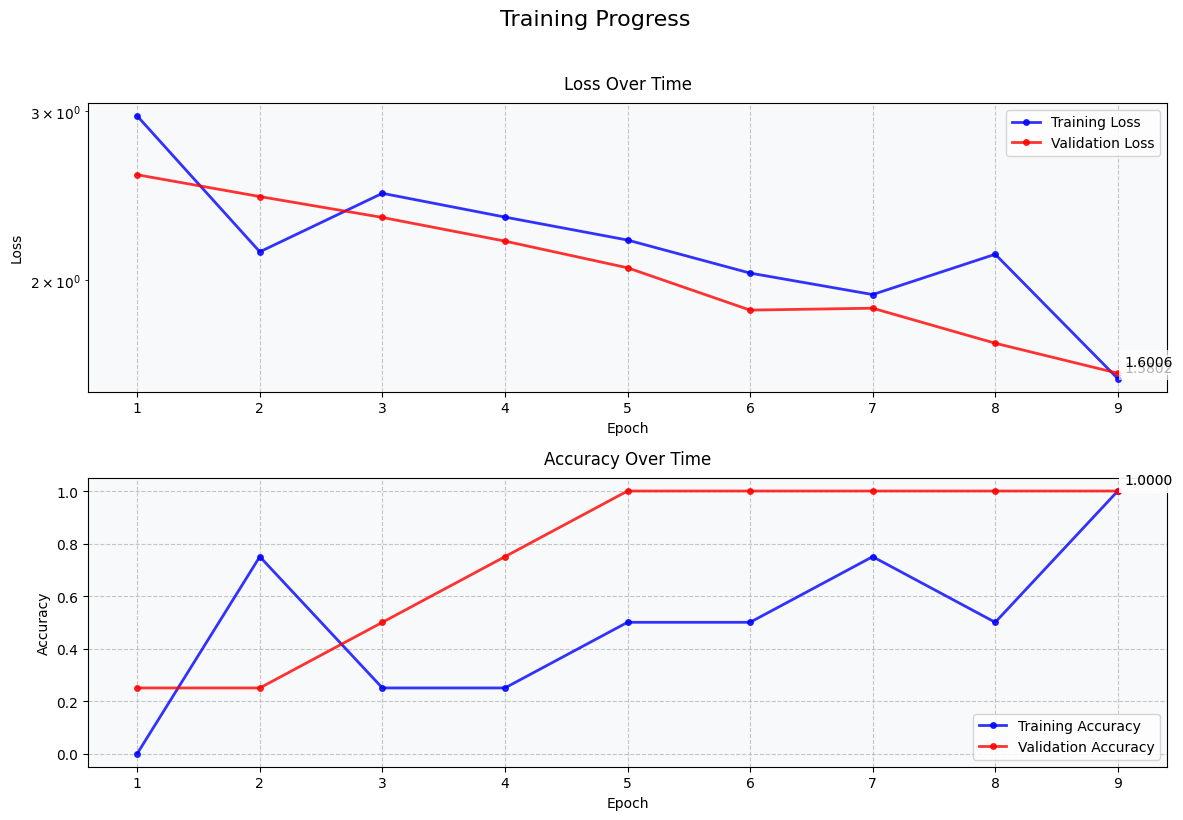

<Figure size 640x480 with 0 Axes>

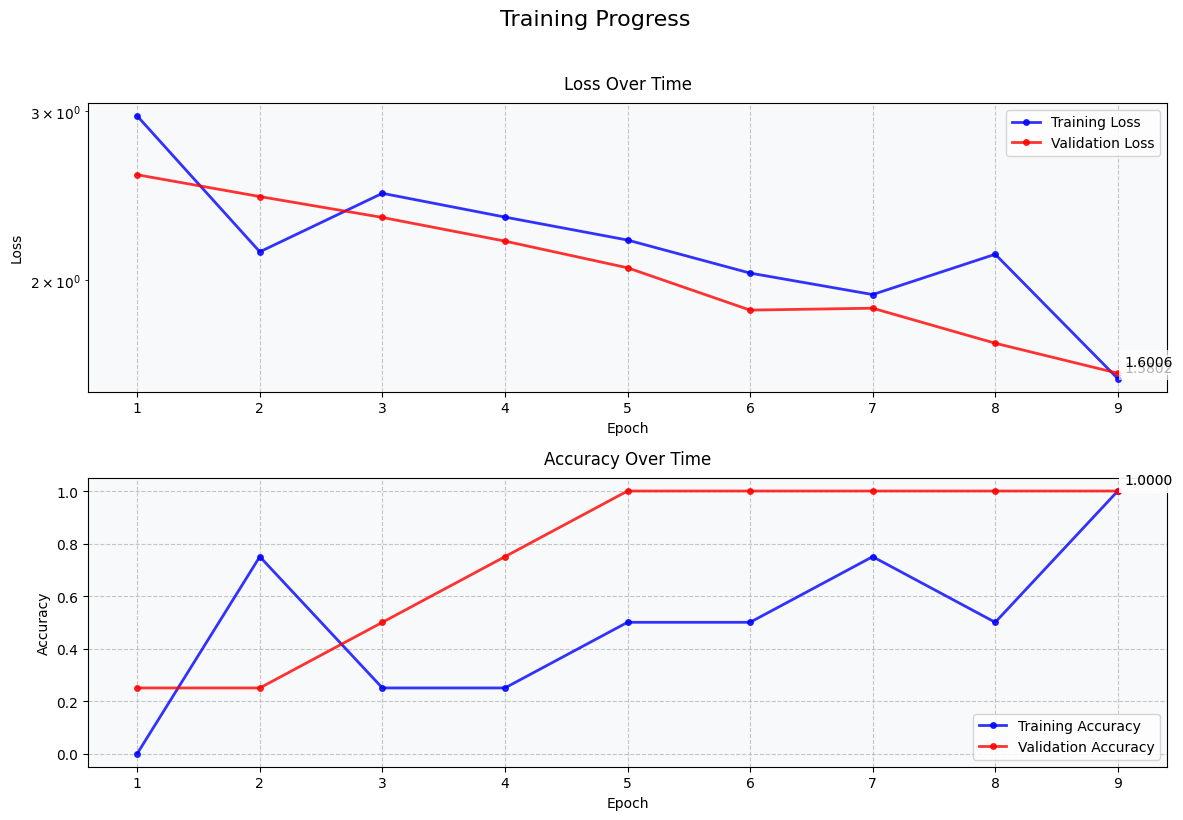

In [16]:
N_EPOCHS = 9
MAX_PATIENCE = 5
LEARNING_RATE = 1e-4
LR_DECAY = 0.995
DECAY_LR_EVERY_N_EPOCHS = 1
EXPERIMENT_NAME = 'exp1'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = vgg.to(device)
criterion = nn.CrossEntropyLoss().to(device)
logger = get_logger(ch_log_level=logging.INFO, fh_log_level=logging.INFO)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print('  + Number of params: {}'.format(
    sum([p.data.nelement() for p in model.parameters()])))
exp = Experiment(EXPERIMENT_NAME, "exps", logger)

# Create New Experiment
exp.init()
#monitor = setup_training_monitor(exp)
#monitor.start()
monitor = ColabTrainingMonitor()
import time

for epoch in range(exp.epoch, exp.epoch+N_EPOCHS):
    since = time.time()

    ### Train ###
    trn_loss, trn_acc = train(model, trainloader, criterion, optimizer, epoch)
    logger.info('Epoch {:d}: Train - Loss: {:.4f}\tAcc: {:.4f}'.format(epoch, trn_loss, trn_acc))    
    time_elapsed = time.time() - since  
    logger.info('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    ### Test ###
    val_loss, val_acc = test(model, testloader, criterion, epoch)    
    logger.info('Val - Loss: {:.4f}, Acc: {:.4f}'.format(val_loss, val_acc))
    time_elapsed = time.time() - since  
    logger.info('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))

    monitor.update(epoch, trn_loss, val_loss, trn_acc, val_acc)

    ### Save Metrics ###
    exp.save_history('train', trn_loss, trn_acc)
    exp.save_history('val', val_loss, val_acc)
    
    ### Checkpoint ###    
    exp.save_weights(model, trn_loss, val_loss, trn_acc, val_acc)
    exp.save_optimizer(optimizer, val_loss)
    
    ## Early Stopping ##
    if (epoch - exp.best_val_loss_epoch) > MAX_PATIENCE:
        logger.info(("Early stopping at epoch %d since no " 
               + "better loss found since epoch %.3") 
               % (epoch, exp.best_val_loss))
        break

    ### Adjust Lr ###
    adjust_learning_rate(LEARNING_RATE, LR_DECAY, optimizer, 
                         epoch, DECAY_LR_EVERY_N_EPOCHS)
    
    exp.epoch += 1

try:
    monitor.save(os.path.join(exp.history_dir, 'final_training_progress.png'))
    monitor.stop()
except:
    pass

In [13]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.init as init
import os

def train(net, dataloader, criterion, optimizer, epoch=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    net.train()
    n_batches = len(dataloader)
    total_loss = 0
    total_acc = 0
    for inputs,targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        ## Forward Pass
        output = net(inputs)
        
        ## Clear Gradients
        net.zero_grad()
        
        loss = criterion(output, targets)
    
        ## Backprop
        loss.backward()
        optimizer.step()
    
        preds = get_predictions(output)
        accuracy = get_accuracy(preds, targets.data.cpu().numpy())
    
        total_loss += loss.item()
        total_acc += accuracy
    
    mean_loss = total_loss / n_batches
    mean_acc = total_acc / n_batches
    return mean_loss, mean_acc

def get_predictions(model_output):
    # Flatten and Get ArgMax to compute accuracy
    val,idx = torch.max(model_output, dim=1)
    return idx.data.cpu().view(-1).numpy()

def get_accuracy(preds, targets):
    correct = np.sum(preds==targets)
    return correct / len(targets)

def test(net, test_loader, criterion, epoch=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.eval()
    test_loss = 0
    test_acc = 0
    with torch.no_grad():  # Disabilita il calcolo dei gradienti
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)

            output = net(data)  # Calcola le previsioni del modello
            test_loss += criterion(output, target).item()  # Calcola la perdita

            pred = get_predictions(output)  # Ottieni le previsioni dal modello
            test_acc += get_accuracy(pred, target.cpu().numpy())  # Calcola l'accuratezza
    test_loss /= len(test_loader) #n_batches
    test_acc /= len(test_loader)
    return test_loss, test_acc

def adjust_learning_rate(lr, decay, optimizer, cur_epoch, n_epochs):
    """Sets the learning rate to the initially 
        configured `lr` decayed by `decay` every `n_epochs`"""
    new_lr = lr * (decay ** (cur_epoch // n_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_uniform(m.weight) 
        m.bias.data.zero_()

def save_weights(model, weights_dir, epoch):
    weights_fname = 'weights-%d.pth' % (epoch)
    weights_fpath = os.path.join(weights_dir, weights_fname)
    torch.save({'state_dict': model.state_dict()}, weights_fpath)

def load_weights(model, fpath):
    model.load_state_dict(state['state_dict'])
    state = torch.load(fpath)